In [1]:
#### Descobrir o portfolio ###

In [588]:
import investpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [406]:
## Ativos e Periodos

ativos = ['ITUB4', 'PETR4', 'BBDC4', 'ABEV3', 'MGLU3', 'WEGE3', 'BBAS3', \
        'VALE3', 'LAME4', 'VVAR3', 'BBDC3', 'BPAC11', 'BBSE3', 'ELET6']

fromdate = '01/01/2018'
todate = '01/08/2022'

In [407]:
## Baixa os ativos para um DF
df_precos = pd.DataFrame()

for acao in ativos:
    
    try:
        p = pd.Series(investpy.get_stock_historical_data(stock=acao,
                   country='brazil',
                   from_date= fromdate,
                   to_date= todate)['Close'],name=acao)
    
        df_precos = pd.concat([df_precos,p], axis = 1)
    except:
        pass

df_precos.dropna(how='any', inplace=True)

In [408]:
df_retornos = df_precos.pct_change(1)[1:]

In [409]:
### Cria um portfolio aleatório

def gerarPorfolio(duracao, ativos, seed = 0, variacao = 0.05):

    if seed != 0:
        np.random.seed(seed)

    m = np.zeros((duracao,ativos))

    ini = np.random.uniform(0,1,ativos)
    m[0] = ini/sum(ini)
    m_1 = m[0]

    for i in range(len(m)-1):
        add = np.random.normal(0,variacao/ativos,ativos)
        temp = m[i] + add
        m[i+1] = temp/sum(temp)
        

    return m


In [410]:
masterFIA = gerarPorfolio(900,len(df_retornos.T))

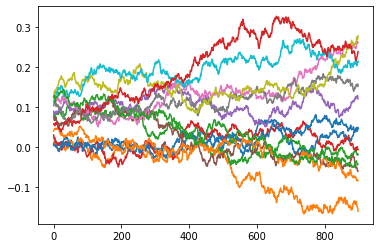

array([0.00608, 0.00775, 0.08301, 0.03104, 0.09032, 0.07565, 0.12339,
       0.10424, 0.12703, 0.11487, 0.00961, 0.04115, 0.12696, 0.0589 ])

In [411]:
plt.plot(masterFIA)
plt.show()
masterFIA[0]

In [413]:
cota = np.cumprod(1+np.diag(df_retornos.iloc[0:900,0:len(df_retornos.T)].dot(masterFIA.T)))
cota

array([0.99833, 1.00305, 1.00122, 1.01066, 1.00243, 0.99012, 1.00206,
       1.00259, 1.00856, 1.006  , 1.02008, 1.01674, 1.02872, 1.02654,
       1.01691, 1.07148, 1.09888, 1.07921, 1.0731 , 1.0777 , 1.0845 ,
       1.06203, 1.04224, 1.06328, 1.05049, 1.03199, 1.01757, 1.05751,
       1.06397, 1.06345, 1.05798, 1.07087, 1.07803, 1.09661, 1.11164,
       1.12284, 1.11035, 1.09821, 1.10542, 1.10984, 1.11086, 1.09966,
       1.08722, 1.07955, 1.10015, 1.10614, 1.09845, 1.08561, 1.0873 ,
       1.09807, 1.08915, 1.08506, 1.09405, 1.10334, 1.10377, 1.11872,
       1.10514, 1.1052 , 1.11938, 1.11332, 1.11363, 1.11011, 1.12191,
       1.10769, 1.07859, 1.08269, 1.09312, 1.10215, 1.0872 , 1.07171,
       1.08201, 1.10029, 1.10285, 1.10949, 1.11216, 1.118  , 1.11655,
       1.1246 , 1.13612, 1.12672, 1.11168, 1.08157, 1.07939, 1.06531,
       1.08652, 1.10559, 1.11384, 1.11322, 1.09369, 1.09172, 1.11002,
       1.07903, 1.06871, 1.05849, 1.0861 , 1.05579, 1.05125, 1.04335,
       0.97816, 0.98

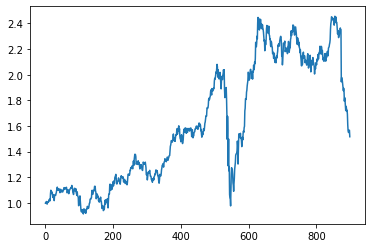

In [414]:
plt.plot(cota)
plt.show()

In [415]:
guess[0]

0.05800475363946146

In [671]:
### A composição do primeiro dia é conhecido. Por exemplo, pela carteira divulgada na CVM. ###
guess = masterFIA[0]
guess


array([0.00608, 0.00775, 0.08301, 0.03104, 0.09032, 0.07565, 0.12339,
       0.10424, 0.12703, 0.11487, 0.00961, 0.04115, 0.12696, 0.0589 ])

In [577]:
### 

def openTheBox(initGuess, cota, retornosAtivos):

    guess = np.empty((len(cota),len(retornosAtivos.T)), dtype=np.float32)
    guess[0] = initGuess/sum(initGuess)
    #print(sum(guess[0]))

    for i in range(len(cota)-1):
        ret = retornosAtivos.iloc[i+1].values
        temp = guess[i].dot(ret)
        #print(temp)
        e = ((cota[i+1]/cota[i])-1) - temp
        #print(ret)
        r2 = ret.dot(ret)
        #print(r2)
        lagrange = e/(1*r2)
        #print(lagrange)
        g = lagrange * ret
        guess[i+1] = (guess[i] + g)/sum((guess[i] + g))
        #print(sum(guess[i]))

    return guess


In [578]:
np.set_printoptions(precision=5)
a = openTheBox(guess, cota, df_retornos[0:9000])

In [579]:
print(a[0])
sum(a[1])

[0.00608 0.00775 0.08301 0.03104 0.09032 0.07565 0.12339 0.10424 0.12703
 0.11487 0.00961 0.04115 0.12696 0.0589 ]


1.0000000074505806

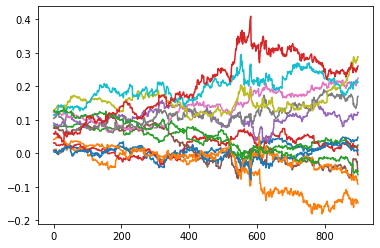

In [580]:
plt.plot(a)
plt.show()

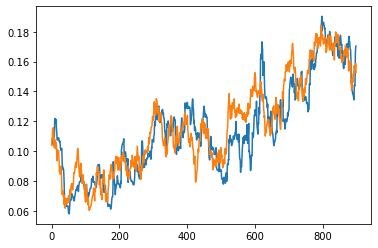

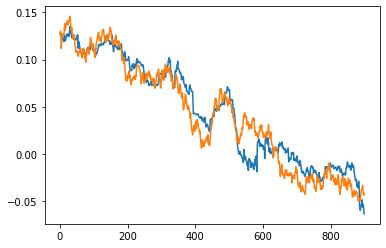

In [581]:
plt.plot(a[:,7])
plt.plot(masterFIA[:,7])
plt.show()

plt.plot(a[:,12])
plt.plot(masterFIA[:,12])
plt.show()

In [582]:
b = 0

for i in range(14):
    b += np.corrcoef(a[:,i],masterFIA[:,i])[0,1]

print(b)

11.445376118192097


In [583]:
cotaReplica = np.cumprod(1+np.diag(df_retornos.iloc[1:900,0:len(df_retornos.T)].dot(a.T)))
cotaReplica

array([1.00495, 1.00306, 1.01208, 1.00429, 0.99244, 1.00469, 1.00504,
       1.01106, 1.00947, 1.02381, 1.02037, 1.03166, 1.03023, 1.01904,
       1.07137, 1.09705, 1.07739, 1.07073, 1.07554, 1.08178, 1.05939,
       1.04042, 1.06232, 1.05104, 1.03335, 1.01945, 1.06066, 1.06746,
       1.06631, 1.06083, 1.07072, 1.07708, 1.09537, 1.10755, 1.11848,
       1.10731, 1.0934 , 1.0995 , 1.10378, 1.10455, 1.09471, 1.08347,
       1.07546, 1.09622, 1.10224, 1.09486, 1.08195, 1.08344, 1.09357,
       1.08219, 1.07794, 1.08745, 1.09749, 1.0987 , 1.11552, 1.10239,
       1.1025 , 1.11559, 1.10909, 1.10866, 1.10521, 1.11721, 1.10326,
       1.07521, 1.07947, 1.08974, 1.09906, 1.08323, 1.06754, 1.07736,
       1.09473, 1.09714, 1.10402, 1.10619, 1.11159, 1.11021, 1.11661,
       1.12765, 1.11901, 1.10217, 1.07176, 1.06935, 1.05592, 1.07742,
       1.09539, 1.10263, 1.10142, 1.08305, 1.07988, 1.09756, 1.06571,
       1.0549 , 1.04469, 1.07054, 1.04245, 1.03764, 1.02791, 0.96443,
       0.97125, 0.98

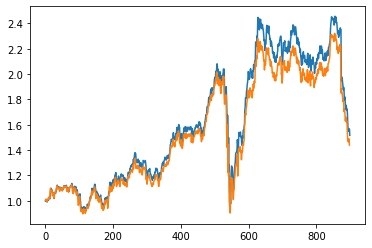

In [584]:
plt.plot(cota)
plt.plot(cotaReplica)
plt.show()

In [585]:
b = np.trace(a.dot(masterFIA.T).dot(masterFIA.dot(a.T)))

In [586]:
c = np.trace(a.dot(a.T).dot(a.dot(a.T)))
d = np.trace(masterFIA.dot(masterFIA.T).dot(masterFIA.dot(masterFIA.T)))

In [587]:
rv = b/((c*d)**0.5)
rv

0.9918260910588815

In [747]:
def target(guess, cota, retornos, reg):
    return (retornos.dot(guess) - cota)**2 + reg * guess.dot(guess)


def openTheBox2(initGuess, cota, retornosAtivos):

    guess = np.empty((len(cota),len(retornosAtivos.T)), dtype=np.float32)
    guess[0] = initGuess/sum(initGuess)
    #print(sum(guess[0]))

    for i in range(len(cota)-1):
        ret = retornosAtivos.iloc[i+1].values
        x0 = np.zeros(len(guess[0]))
        temp = guess[i].dot(ret)
        e = ((cota[i+1]/cota[i])-1) - temp
        g = minimize(target,x0,args=(e,ret,0.1))
        guess[i+1] = (guess[i] + g.x)/np.sum((guess[i] + g.x))

    return guess

In [748]:
a2 = openTheBox2(guess, cota[0:900], df_retornos[0:900])

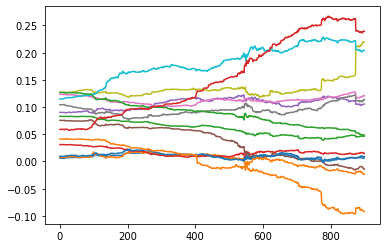

In [749]:
plt.plot(a2)
plt.show()

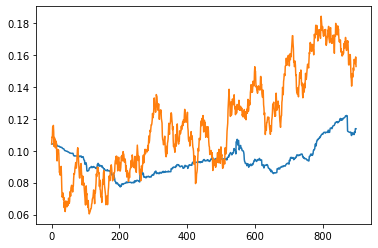

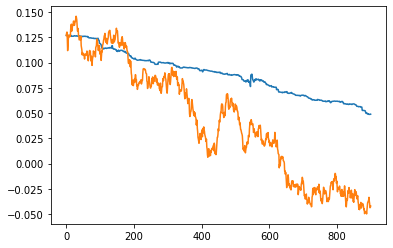

In [750]:
plt.plot(a2[:,7])
plt.plot(masterFIA[:900,7])
plt.show()

plt.plot(a2[:,12])
plt.plot(masterFIA[:900,12])
plt.show()